In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# GPU Config
import tensorflow as tf

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    print("No GPU devices found. Ensure your system recognizes the GPU.")
else:
    try:
        # Limit TensorFlow to use only the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print(f"Configured TensorFlow to use GPU: {gpus[0].name}")

        # Enable dynamic memory growth on the GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Memory growth enabled for the first GPU.")

        # Optional: Display additional GPU configuration details
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")

    except RuntimeError as e:
        print(f"RuntimeError during GPU setup: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Further GPU diagnostics
print("TensorFlow version:", tf.__version__)
print("CUDA device detected:", tf.test.is_built_with_cuda())
print("GPU availability:", tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

gpus

Configured TensorFlow to use GPU: /physical_device:GPU:0
Memory growth enabled for the first GPU.
Physical GPUs: 1, Logical GPUs: 1
TensorFlow version: 2.17.0
CUDA device detected: True
GPU availability: True


I0000 00:00:1731203979.671701   17814 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

I0000 00:00:1731203979.671853   17814 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731203979.671903   17814 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731203979.671980   17814 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731203979.672028   17814 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [5]:
from eurosat_model import create_extended_generators, plot_training_history

data_dir = './data/2750/'

# Create the data generators
train_generator, val_generator, test_generator = create_extended_generators(
    data_dir=data_dir,
    img_size=(64, 64),
    batch_size=32,
    validation_split=0.2,
    test_split=0.1
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Found 3600 images belonging to 10 classes.
Found 1800 images belonging to 10 classes.


## AlexNet

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (64, 64, 3)
num_classes = 10

# Configuración del modelo
alexnet = Sequential()

# Primera capa convolucional
alexnet.add(Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=input_shape))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Segunda capa convolucional
alexnet.add(Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Tercera, cuarta y quinta capas convolucionales
alexnet.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
alexnet.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
alexnet.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=2))

# Aplanamiento y capas densas
alexnet.add(Flatten())
alexnet.add(Dense(4096, activation='relu'))
alexnet.add(Dropout(0.5))
alexnet.add(Dense(4096, activation='relu'))
alexnet.add(Dropout(0.5))

# Capa de salida
alexnet.add(Dense(num_classes, activation='softmax'))  

# Compilación del modelo
alexnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
alexnet.summary()

/home/federico/Projects/imgClassification/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,623,562 (82.49 MB)

 Trainable params: 21,622,858 (82.48 MB)

 Non-trainable params: 704 (2.75 KB)

In [7]:
# Use only EarlyStopping when using LearningRateSchedule
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = alexnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping]  # Only use callbacks that do not alter the learning rate
)

Epoch 1/15


/home/federico/Projects/imgClassification/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731203983.501910   17910 service.cc:146] XLA service 0x7fada4006c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731203983.501938   17910 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-11-09 22:59:43.538676: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-09 22:59:43.727977: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN ver

  6/675 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.0470 - loss: 3.2150  

I0000 00:00:1731203986.103486   17910 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


672/675 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3266 - loss: 1.8151

2024-11-09 23:00:07.432347: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_148', 132 bytes spill stores, 132 bytes spill loads

2024-11-09 23:00:07.557490: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_148', 16 bytes spill stores, 16 bytes spill loads

2024-11-09 23:00:07.609291: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_155', 188 bytes spill stores, 188 bytes spill loads

2024-11-09 23:00:09.813951: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_148', 20 bytes spill stores, 20 bytes spill loads



675/675 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.3271 - loss: 1.8137 - val_accuracy: 0.3439 - val_loss: 2.3099
Epoch 2/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.5563 - loss: 1.2426 - val_accuracy: 0.5728 - val_loss: 1.2406
Epoch 3/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.6181 - loss: 1.0908 - val_accuracy: 0.2242 - val_loss: 4.7695
Epoch 4/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.6330 - loss: 1.0441 - val_accuracy: 0.6461 - val_loss: 1.0235
Epoch 5/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.6537 - loss: 0.9911 - val_accuracy: 0.5331 - val_loss: 1.8583
Epoch 6/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.6618 - loss: 0.9556 - val_accuracy: 0.6858 - val_loss: 0.8501
Epoch 7/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.6718 - loss: 0.9296 - val_accuracy: 0.2839 - val_loss: 3.8284
Epoch 8/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.6873 - loss: 0.8961 - val_accurac

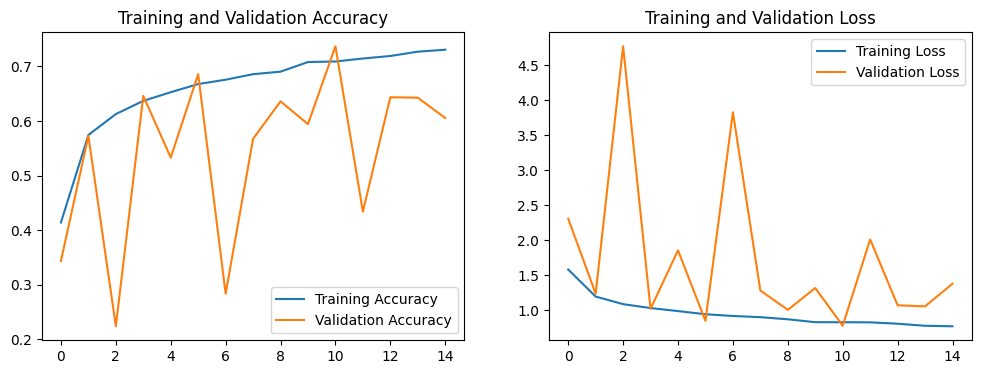

In [8]:
# Plot training history
plot_training_history(history)


## ResNet

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Add, Activation, BatchNormalization, GlobalAveragePooling2D

# Definición de un bloque residual
def residual_block(x, filters, kernel_size=(3, 3), stride=1):
    # Primera capa convolucional
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Segunda capa convolucional
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Skip connection
    if stride > 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Definición de la entrada
input_tensor = Input(shape=(64, 64, 3))

# Primeras capas convolucionales
x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

# Bloques residuales
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)

x = residual_block(x, filters=128, stride=2)
x = residual_block(x, filters=128)

x = residual_block(x, filters=256, stride=2)
x = residual_block(x, filters=256)

x = residual_block(x, filters=512, stride=2)
x = residual_block(x, filters=512)

# Capa de pooling global y capa de salida
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(10, activation='softmax')(x)

# Creación del modelo
resnet = Model(inputs=input_tensor, outputs=output_tensor)
resnet.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     36,928 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 16,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ activation_1[0][

 Total params: 11,196,042 (42.71 MB)

 Trainable params: 11,186,442 (42.67 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [10]:
resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use only EarlyStopping when using LearningRateSchedule
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]  # Only use callbacks that do not alter the learning rate
)

Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.5009 - loss: 1.4828 - val_accuracy: 0.1656 - val_loss: 16.9979
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.6458 - loss: 0.9866 - val_accuracy: 0.2597 - val_loss: 7.6583
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.7097 - loss: 0.8193 - val_accuracy: 0.3958 - val_loss: 3.0230
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.7427 - loss: 0.7332 - val_accuracy: 0.7344 - val_loss: 0.7725
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.7841 - loss: 0.6254 - val_accuracy: 0.5094 - val_loss: 1.8012
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.8048 - loss: 0.5504 - val_accuracy: 0.6328 - val_loss: 1.4665
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8346 - loss: 0.4819 - val_accuracy: 0.6419 - val_loss: 1.1148
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.8540 - loss: 0.4234 -

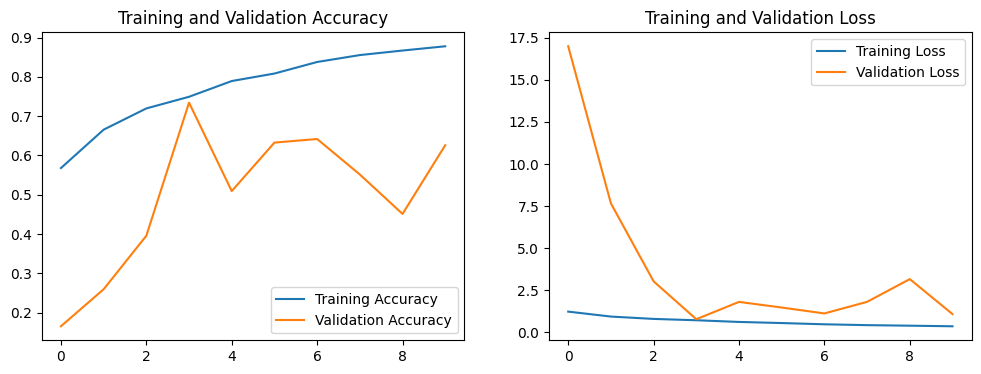

In [11]:
# Plot training history
plot_training_history(history)


## VGG - OptA

In [12]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Cargar el modelo VGG16 preentrenado en ImageNet, ajustando la entrada a 64x64 y sin incluir la capa de clasificación superior
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Congelar las capas del modelo base para evitar que se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas densas personalizadas para la clasificación
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)  # Ajustar para 10 clases

# Crear el modelo final
vgg = Model(inputs=base_model.input, outputs=output)

# Compilar el modelo
vgg.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
vgg.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        40,97

 Total params: 39,929,674 (152.32 MB)

 Trainable params: 25,214,986 (96.19 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use only EarlyStopping when using LearningRateSchedule
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = vgg.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]  # Only use callbacks that do not alter the learning rate
)

Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.5750 - loss: 1.2933 - val_accuracy: 0.7494 - val_loss: 0.7275
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.7125 - loss: 0.8169 - val_accuracy: 0.8094 - val_loss: 0.5821
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.7285 - loss: 0.8033 - val_accuracy: 0.8192 - val_loss: 0.5492
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.7491 - loss: 0.7464 - val_accuracy: 0.7942 - val_loss: 0.5795
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.7550 - loss: 0.7162 - val_accuracy: 0.8128 - val_loss: 0.5588
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.7647 - loss: 0.6928 - val_accuracy: 0.8092 - val_loss: 0.5592
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.7744 - loss: 0.6750 - val_accuracy: 0.8292 - val_loss: 0.5221
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.7694 - loss: 0.6841 - 

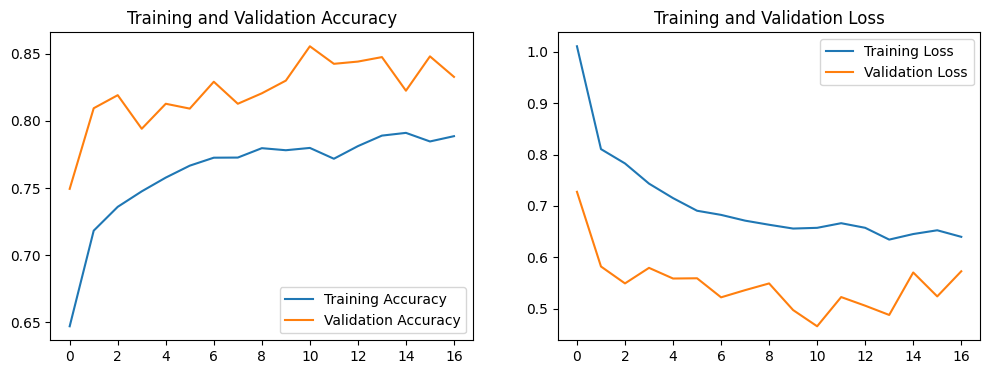

In [14]:
plot_training_history(history)

In [15]:
import numpy as np
import pandas as pd

# Predecir
predictions = vgg.predict(test_generator)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Actual class labels
actual_classes = test_generator.classes

# Get the class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Convert predicted indices to class labels
predicted_labels = [class_labels[i] for i in predicted_classes]

# Create a DataFrame with actual and predicted labels
comparison_df = pd.DataFrame({
    'Actual Label': [class_labels[i] for i in actual_classes],
    'Predicted Label': predicted_labels
})

# Display a random sample of comparisons
sample_comparisons = comparison_df.sample(10)
print(sample_comparisons)


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step
              Actual Label       Predicted Label
1544                 River                 River
1047               Pasture               Pasture
1775               SeaLake               SeaLake
71              AnnualCrop            AnnualCrop
542   HerbaceousVegetation  HerbaceousVegetation
1783               SeaLake               SeaLake
1184         PermanentCrop         PermanentCrop
1432                 River                 River
682                Highway               Highway
321                 Forest                Forest


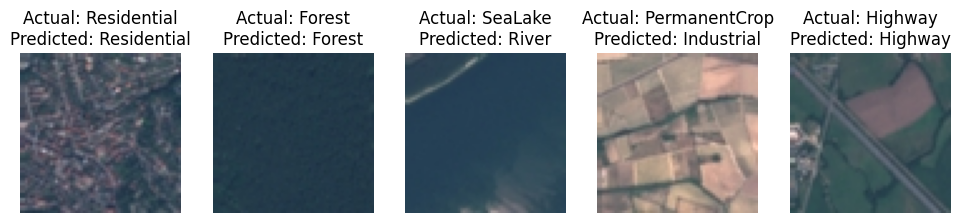

In [16]:
import matplotlib.pyplot as plt

# Get file paths from the test generator
file_paths = test_generator.filepaths

# Select a random subset for visualization
num_samples = 5
indices = np.random.choice(len(file_paths), num_samples, replace=False)

# Plot sample images with actual and predicted labels
plt.figure(figsize=(12, 8))
for i, idx in enumerate(indices):
    img = plt.imread(file_paths[idx])
    plt.subplot(1, num_samples, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {comparison_df['Actual Label'][idx]}\nPredicted: {comparison_df['Predicted Label'][idx]}")
plt.show()

In [17]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.8772222222222222


## VGG - OptB

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models


# Cargar modelo pre-entrenado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Congelar capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas
vgg = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compilar el modelo
vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [19]:
vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use only EarlyStopping when using LearningRateSchedule
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = vgg.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]  # Only use callbacks that do not alter the learning rate
)

Epoch 1/20


2024-11-09 23:17:39.377479: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1623', 32 bytes spill stores, 32 bytes spill loads

2024-11-09 23:17:39.529403: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1623', 8 bytes spill stores, 8 bytes spill loads

2024-11-09 23:17:40.010837: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1623', 32 bytes spill stores, 32 bytes spill loads

2024-11-09 23:17:40.369546: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1623', 32 bytes spill stores, 32 bytes spill loads



675/675 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.5268 - loss: 1.3205 - val_accuracy: 0.7600 - val_loss: 0.7160
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.7320 - loss: 0.7673 - val_accuracy: 0.7978 - val_loss: 0.6026
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.7659 - loss: 0.6757 - val_accuracy: 0.8167 - val_loss: 0.5462
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.7766 - loss: 0.6415 - val_accuracy: 0.8225 - val_loss: 0.5121
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.7908 - loss: 0.6000 - val_accuracy: 0.8153 - val_loss: 0.5252
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.7966 - loss: 0.5778 - val_accuracy: 0.8378 - val_loss: 0.4840
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.8018 - loss: 0.5674 - val_accuracy: 0.8292 - val_loss: 0.4889
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 35s 52ms/step - accuracy: 0.7994 - loss: 0.5770 - val_accurac

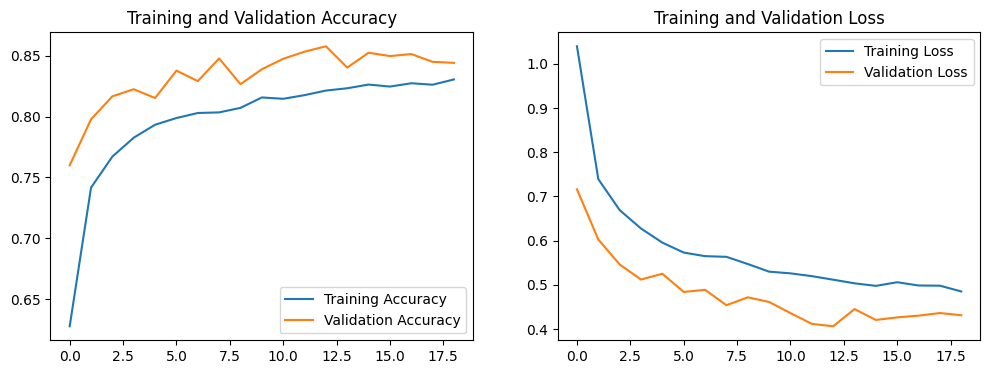

In [20]:
plot_training_history(history)

## Basic Cnn with Avg Pooling

In [21]:
from eurosat_model import build_cnn_model_rev

In [22]:
input_shape = (64, 64, 3)
num_classes = 10  # classes in EuroSAT

# Build and summarize the CNN model
basic_cnn = build_cnn_model_rev(input_shape, num_classes)

basic_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,322 (645.79 KB)

 Trainable params: 164,874 (644.04 KB)

 Non-trainable params: 448 (1.75 KB)

In [23]:
basic_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = basic_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=8,
    callbacks=[EarlyStopping(monitor='val_loss', patience=6)]
)

Epoch 1/8


2024-11-09 23:27:30.610884: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1521', 8 bytes spill stores, 8 bytes spill loads

2024-11-09 23:27:31.638188: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1521', 32 bytes spill stores, 32 bytes spill loads

2024-11-09 23:27:32.101496: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1234', 8 bytes spill stores, 8 bytes spill loads

2024-11-09 23:27:32.349237: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1521', 32 bytes spill stores, 32 bytes spill loads



675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.6115 - loss: 1.0731 - val_accuracy: 0.6450 - val_loss: 0.9786
Epoch 2/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.7670 - loss: 0.6503 - val_accuracy: 0.6092 - val_loss: 1.3808
Epoch 3/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.8142 - loss: 0.5303 - val_accuracy: 0.7731 - val_loss: 0.6688
Epoch 4/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8483 - loss: 0.4367 - val_accuracy: 0.8061 - val_loss: 0.5435
Epoch 5/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.8686 - loss: 0.3685 - val_accuracy: 0.8111 - val_loss: 0.6111
Epoch 6/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8863 - loss: 0.3277 - val_accuracy: 0.8469 - val_loss: 0.4455
Epoch 7/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.8901 - loss: 0.3146 - val_accuracy: 0.8297 - val_loss: 0.4856
Epoch 8/8
675/675 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8966 - loss: 0.3033 - val_accuracy: 0.30

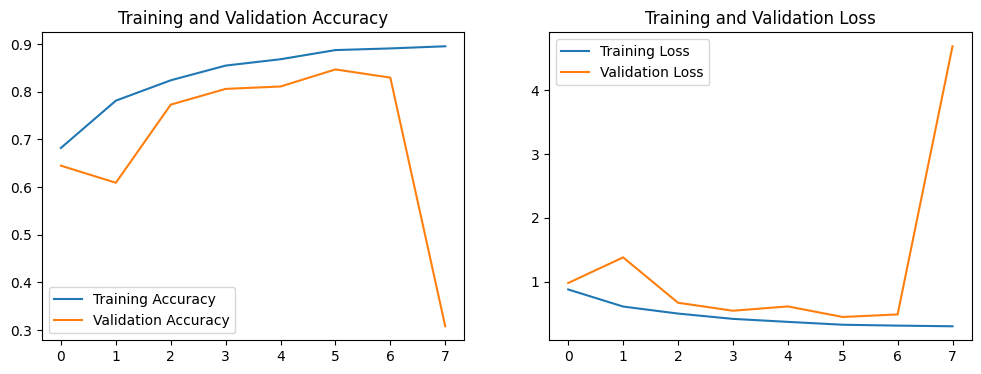

In [24]:
plot_training_history(history)

## Adjust data augmentation + lr scheduling

In [25]:
from eurosat_model import create_extended_generators_with_brightness_contrast
data_dir = './data/2750/'

# Create the data generators
train_generator, val_generator, test_generator = create_extended_generators_with_brightness_contrast(
    data_dir=data_dir,
    img_size=(48, 48),
    batch_size=16,
    validation_split=0.2,
    test_split=0.1
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Found 3600 images belonging to 10 classes.
Found 1800 images belonging to 10 classes.


In [26]:
from eurosat_model import build_cnn_model_lite
input_shape = (64, 64, 3)
num_classes = 10  # classes in EuroSAT

reduced_cnn = build_cnn_model_lite(input_shape, num_classes)

/home/federico/Projects/imgClassification/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
reduced_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# EarlyStopping y ReduceLROnPlateau para ajustes adicionales
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

# crear el scheduler
manual_lr = True

if manual_lr:
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[3, 6, 9, 12, 15],
    values=[0.01, 0.008, 0.006, 0.004, 0.002, 0.001]
)
    callback_list = [early_stopping]

else:
    # Esto me derrite el kernel con una RTX4070(12GB)
    initial_learning_rate = 0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=500,
        decay_rate=0.9,
        staircase=True
    )
    lr_reduction = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )
    callback_list = [early_stopping, lr_reduction]

# Configurar Adam con el scheduler
adam_config = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

batch_size = 16  # Reducido para menos carga en la memoria
steps_per_epoch = 21600 // batch_size
validation_steps = 5400 // batch_size

reduced_cnn.compile(optimizer=adam_config,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Entrenamiento
history = reduced_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callback_list 
)


Epoch 1/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.2409 - loss: 1.9655 - val_accuracy: 0.5319 - val_loss: 1.3308
Epoch 2/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.4723 - loss: 1.4061 - val_accuracy: 0.5349 - val_loss: 1.1972
Epoch 3/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5472 - loss: 1.2280 - val_accuracy: 0.5736 - val_loss: 1.1815
Epoch 4/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.6004 - loss: 1.0918 - val_accuracy: 0.6148 - val_loss: 1.0512
Epoch 5/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.6265 - loss: 1.0176 - val_accuracy: 0.6205 - val_loss: 1.1199
Epoch 6/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.6498 - loss: 0.9591 - val_accuracy: 0.7168 - val_loss: 0.8472
Epoch 7/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.6555 - loss: 0.9360 - val_accuracy: 0.6767 - val_loss: 0.9416
Epoch 8/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6754 -

2024-11-09 23:44:23.592240: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


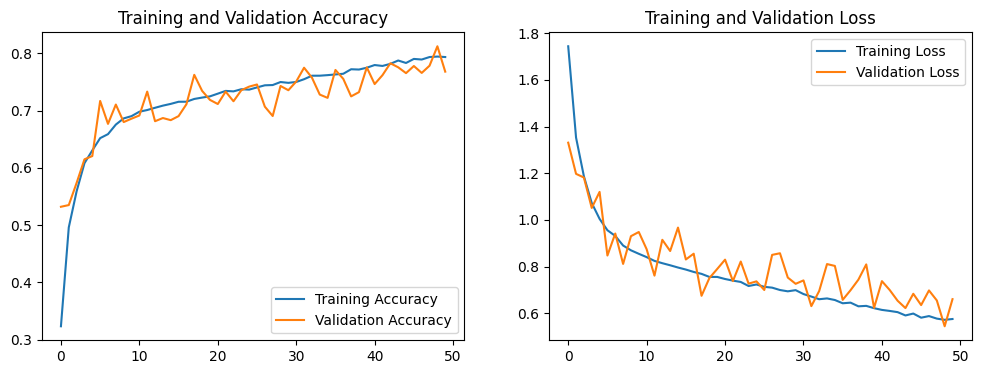

In [29]:
from eurosat_model import plot_training_history
plot_training_history(history)

## Transfer learning - Pretrained ResNet (Use tif instead of jpg)

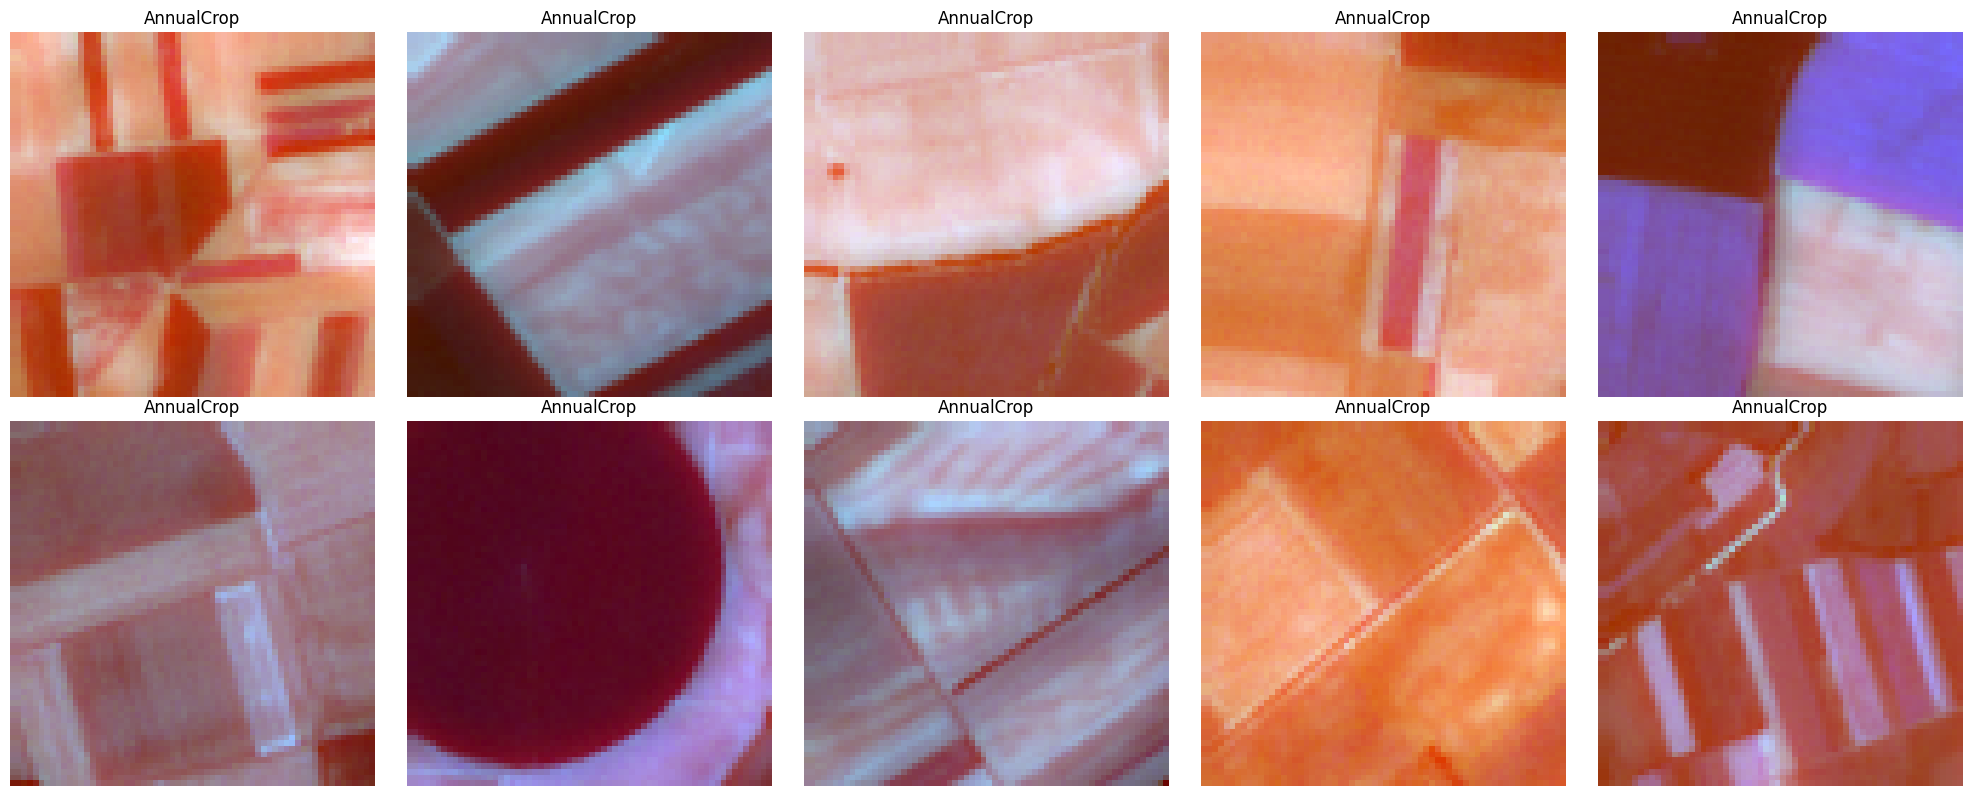

In [30]:
# Load tiff with rasterio
#import os
import numpy as np
import matplotlib.pyplot as plt

# Importaciones adicionales
from sklearn.model_selection import train_test_split

# eurosat
from eurosat_model import load_eurosat_dataset

# Lista de clases (necesaria para visualización)
classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
           'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Cargar y dividir un sample dataset
X, y = load_eurosat_dataset('./data/sentinel_2/tif')

# Opt a
# Visualizar algunas imágenes del dataset
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axes.flat):
    img = X[i][..., :3]  # Selecciona solo los primeros 3 canales
    img = (img - img.min()) / (img.max() - img.min())  # Normalización a [0, 1]
    ax.imshow(img)
    ax.set_title(classes[y[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [31]:
import tensorflow as tf

from eurosat_model import (
    load_eurosat_dataset_with_msavi, unfreeze_and_finetune, 
    evaluate_model, evaluate_model_in_batches
)

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from eurosat_model import create_adapted_resnet, create_resnet_transfer_model

# Cargar el dataset completo
X, y = load_eurosat_dataset_with_msavi('./data/sentinel_2/tif', num_samples=27000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir etiquetas a formato one-hot
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

Evaluando modelo con tamaño de entrada original



Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 64, 64, 3)      │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,841 (91.99 MB)

 Trainable params: 527,129 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
Epoch 1/15


2024-11-09 23:45:19.351137: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5978', 176 bytes spill stores, 468 bytes spill loads

2024-11-09 23:45:19.547241: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6349', 32 bytes spill stores, 32 bytes spill loads

2024-11-09 23:45:19.944260: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6349', 32 bytes spill stores, 32 bytes spill loads

2024-11-09 23:45:20.192320: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6349', 8 bytes spill stores, 8 bytes spill loads

2024-11-09 23:45:20.415537: I external/local_xla/xla/stream_

638/638 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.1029 - loss: 2.5548 - val_accuracy: 0.2035 - val_loss: 2.2529
Epoch 2/15
638/638 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.1241 - loss: 2.3836 - val_accuracy: 0.3000 - val_loss: 2.2135
Epoch 3/15
638/638 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.1531 - loss: 2.3017 - val_accuracy: 0.3296 - val_loss: 2.1795
Epoch 4/15
638/638 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.1720 - loss: 2.2441 - val_accuracy: 0.3278 - val_loss: 2.1476
Epoch 5/15
638/638 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.1915 - loss: 2.1954 - val_accuracy: 0.3371 - val_loss: 2.1193
Epoch 6/15
638/638 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.2043 - loss: 2.1492 - val_accuracy: 0.3702 - val_loss: 2.0929
Epoch 7/15
638/638 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.2312 - loss: 2.1110 - val_accuracy: 0.4384 - val_loss: 2.0684
Epoch 8/15
638/638 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.2400 - loss: 2.0787 - val_accuracy: 0.46

/home/federico/Projects/imgClassification/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/federico/Projects/imgClassification/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/federico/Projects/imgClassification/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

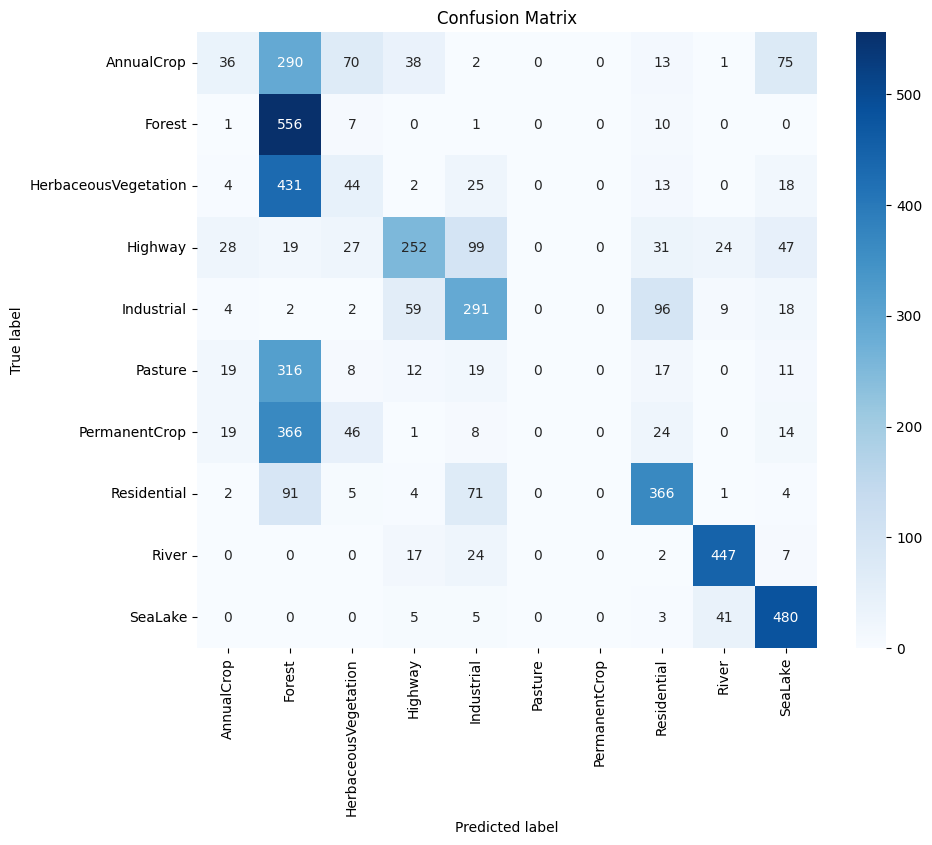

Kappa Score: 0.4234684078298142

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.32      0.07      0.11       525
              Forest       0.27      0.97      0.42       575
HerbaceousVegetation       0.21      0.08      0.12       537
             Highway       0.65      0.48      0.55       527
          Industrial       0.53      0.60      0.57       481
             Pasture       0.00      0.00      0.00       402
       PermanentCrop       0.00      0.00      0.00       478
         Residential       0.64      0.67      0.65       544
               River       0.85      0.90      0.88       497
             SeaLake       0.71      0.90      0.79       534

            accuracy                           0.48      5100
           macro avg       0.42      0.47      0.41      5100
        weighted avg       0.43      0.48      0.42      5100



In [32]:
print("Evaluando modelo con tamaño de entrada original")
print("")
# Crear y compilar el modelo adaptado para 4 canales
adapted_model = create_adapted_resnet(num_classes=10, input_shape=(64, 64, 4))
adapted_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Imprimir resumen del modelo
print(adapted_model.summary())
# Descongelar progresivamente y reducir el learning rate
unfreeze_and_finetune(adapted_model, layers_to_unfreeze=20, learning_rate=1e-5)

# Entrenar con fine-tuning
history_fine = adapted_model.fit(X_train, y_train,
                                epochs=15,
                                validation_data=(X_test, y_test),
                                batch_size=32,
                                callbacks=[EarlyStopping(monitor='val_loss', patience=7)])

# Evaluar el modelo
evaluate_model(adapted_model, X_test, y_test, classes)

In [33]:
def preprocess_image(img, label):
    # Redimensionar y normalizar en el rango [-1, 1] (por compatibilidad con ResNet50)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32)
    
    # Normalizar valores de los pixeles al rango [-1, 1]
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img)) * 2 - 1
    
    return img, label


In [34]:
from tensorflow.keras.callbacks import Callback

class ManualLearningRateScheduler(Callback):
    def __init__(self, schedule):
        super(ManualLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        # Check if the current epoch is in the schedule
        if epoch in self.schedule:
            new_lr = self.schedule[epoch]
            if isinstance(new_lr, (float, int)) and new_lr > 0:
                # Determine the learning rate attribute, depending on TensorFlow version
                if hasattr(self.model.optimizer, "learning_rate"):
                    lr_attr = self.model.optimizer.learning_rate
                elif hasattr(self.model.optimizer, "lr"):
                    lr_attr = self.model.optimizer.lr
                else:
                    print(f"Warning: Unable to set learning rate for optimizer: no learning rate attribute found.")
                    return

                # Set the learning rate only if lr_attr is a valid variable
                if isinstance(lr_attr, tf.Variable) or isinstance(lr_attr, tf.Tensor):
                    tf.keras.backend.set_value(lr_attr, float(new_lr))
                    print(f"\nEpoch {epoch+1}: Learning rate is set to {new_lr}")
                else:
                    print(f"Warning: Learning rate attribute {lr_attr} is not a valid Keras variable.")




In [35]:
print("Evaluando modelo con ajuste del tamaño de entrada a 224")
print("")

# Data Loading Diagnostic: Check batch loading
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(preprocess_image).batch(16).prefetch(tf.data.AUTOTUNE)
print("Checking train dataset loading...")
for batch in train_dataset.take(1):
    print("Train batch loaded successfully.")

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = val_dataset.map(preprocess_image).batch(16).prefetch(tf.data.AUTOTUNE)
print("Checking validation dataset loading...")
for batch in val_dataset.take(1):
    print("Validation batch loaded successfully.")

# Create and compile model
adapted_model = create_resnet_transfer_model(input_shape=(224, 224, 4), num_classes=10)
adapted_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

# Print model summary and optimizer configuration
print(adapted_model.summary())
print(f"Model optimizer: {adapted_model.optimizer}")  # Optimizer and learning rate check

# Define manual learning rate schedule
manual_schedule = {
    0: 1e-4,
    5: 1e-5,
    10: 1e-6
}
lr_scheduler = ManualLearningRateScheduler(schedule=manual_schedule)

# Training with base layers frozen
print("Starting initial training with frozen base layers...")
history_initial = adapted_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3), lr_scheduler]
)

# Unfreeze layers and set lower learning rate for fine-tuning
print("Unfreezing layers and setting learning rate for fine-tuning...")
unfreeze_and_finetune(adapted_model, layers_to_unfreeze=20, learning_rate=1e-5)

# Fine-tuning the model with unfreezing
print("Starting fine-tuning...")
history_fine = adapted_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=7), lr_scheduler]
)

# Evaluate model in batches
#evaluate_model_in_batches(adapted_model, val_dataset, classes)

Evaluando modelo con ajuste del tamaño de entrada a 224

Checking train dataset loading...
Train batch loaded successfully.


2024-11-09 23:47:40.272404: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Checking validation dataset loading...
Validation batch loaded successfully.


2024-11-09 23:47:40.705588: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 224, 224, 3)    │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,841 (91.99 MB)

 Trainable params: 527,129 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
Model optimizer: <keras.src.optimizers.adam.Adam object at 0x7fad4ef034c0>
Starting initial training with frozen base layers...
Epoch 1/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 64s 43ms/step - accuracy: 0.1592 - loss: 2.3436 - val_accuracy: 0.3680 - val_loss: 1.9743
Epoch 2/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - accuracy: 0.3550 - loss: 1.8605 - val_accuracy: 0.4829 - val_loss: 1.4944
Epoch 3/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - accuracy: 0.4389 - loss: 1.4801 - val_accuracy: 0.5676 - val_loss: 1.3027
Epoch 4/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - accuracy: 0.4836 - loss: 1.3308 - val_accuracy: 0.5920 - val_loss: 1.2110
Epoch 5/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 52s 40ms/step - accuracy: 0.5126 - loss: 1.2525 - val_accuracy: 0.6096 - val_loss: 1.1592
Epoch 6/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - accuracy: 0.5416 - loss: 1.1913 - val_accuracy: 0.6290 - val_loss: 1.1091
Epoch 7/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.5667 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━

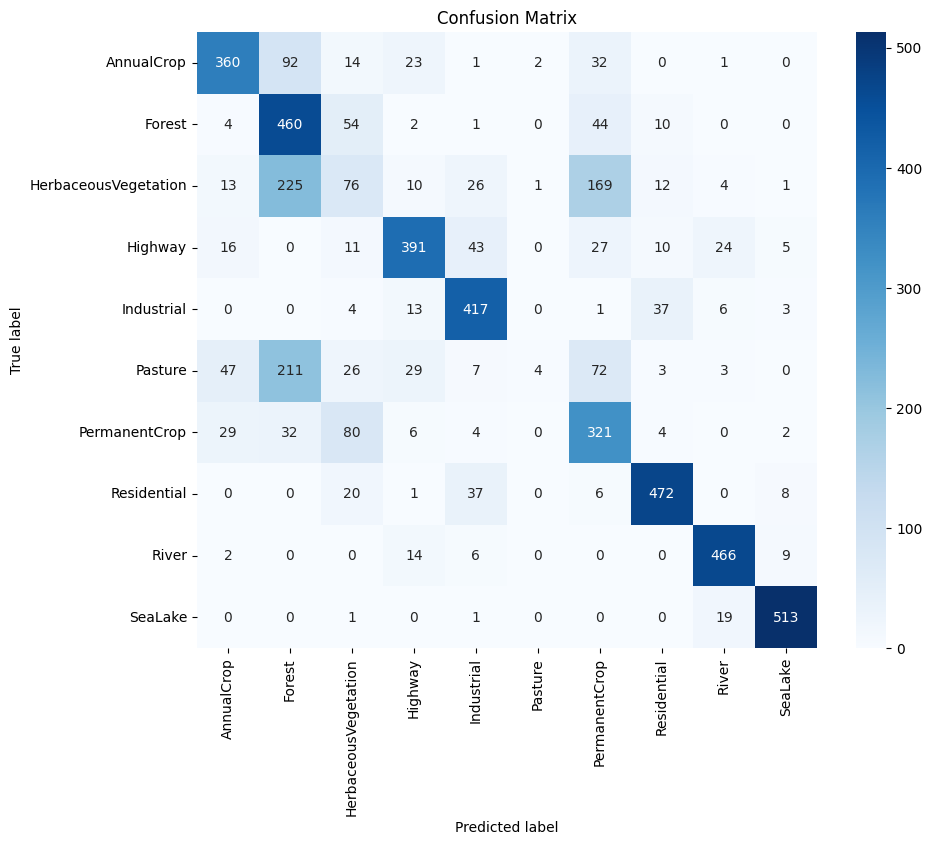

Kappa Score: 0.6459060403835117

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.76      0.69      0.72       525
              Forest       0.45      0.80      0.58       575
HerbaceousVegetation       0.27      0.14      0.18       537
             Highway       0.80      0.74      0.77       527
          Industrial       0.77      0.87      0.81       481
             Pasture       0.57      0.01      0.02       402
       PermanentCrop       0.48      0.67      0.56       478
         Residential       0.86      0.87      0.86       544
               River       0.89      0.94      0.91       497
             SeaLake       0.95      0.96      0.95       534

            accuracy                           0.68      5100
           macro avg       0.68      0.67      0.64      5100
        weighted avg       0.68      0.68      0.65      5100



In [36]:
# PROBAR ESTO
evaluate_model_in_batches(adapted_model, val_dataset, classes)